In [1]:
import numpy as np
import matplotlib.pylab as plt
import xarray as xr

from gf45clo_sin_neff_ng_calculator import mode_data_calculator

import tidy3d as td
from tidy3d.constants import C_0

from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")


In [2]:
Lx, Ly, Lz = 10,10,10
dl = 0.02

min_steps_per_wvl = 15

wg_width_median_array = [0.8, 1.4, 2.0]#, 3.0, 4.0, 5.0]
wg_height_median = 0.3
wg_n = 1.968
wg_k = 0

wvl_um = 1.31
freq0 = C_0/wvl_um

wg_medium = td.Medium.from_nk(n=1.968, k=0, freq=freq0)

wg_sidewall_angle_median = np.pi/2.0 - 87.0/180.0*np.pi

num_freqs = 3

fwidth = 3200e9  # 3200 Ghz
freqs = np.linspace(freq0-fwidth/2.0, freq0+fwidth/2.0, num_freqs)

thickness_3sigma = 0.03
width_3sigma = 0.02
sidewall_angle_3sigma = 2/90*np.pi/2

num_samples = 500

[09:21:36] WARNING: Use the remote mode solver with subpixel averaging for      
           better accuracy through 'tidy3d.plugins.mode.web.run(...)'.          

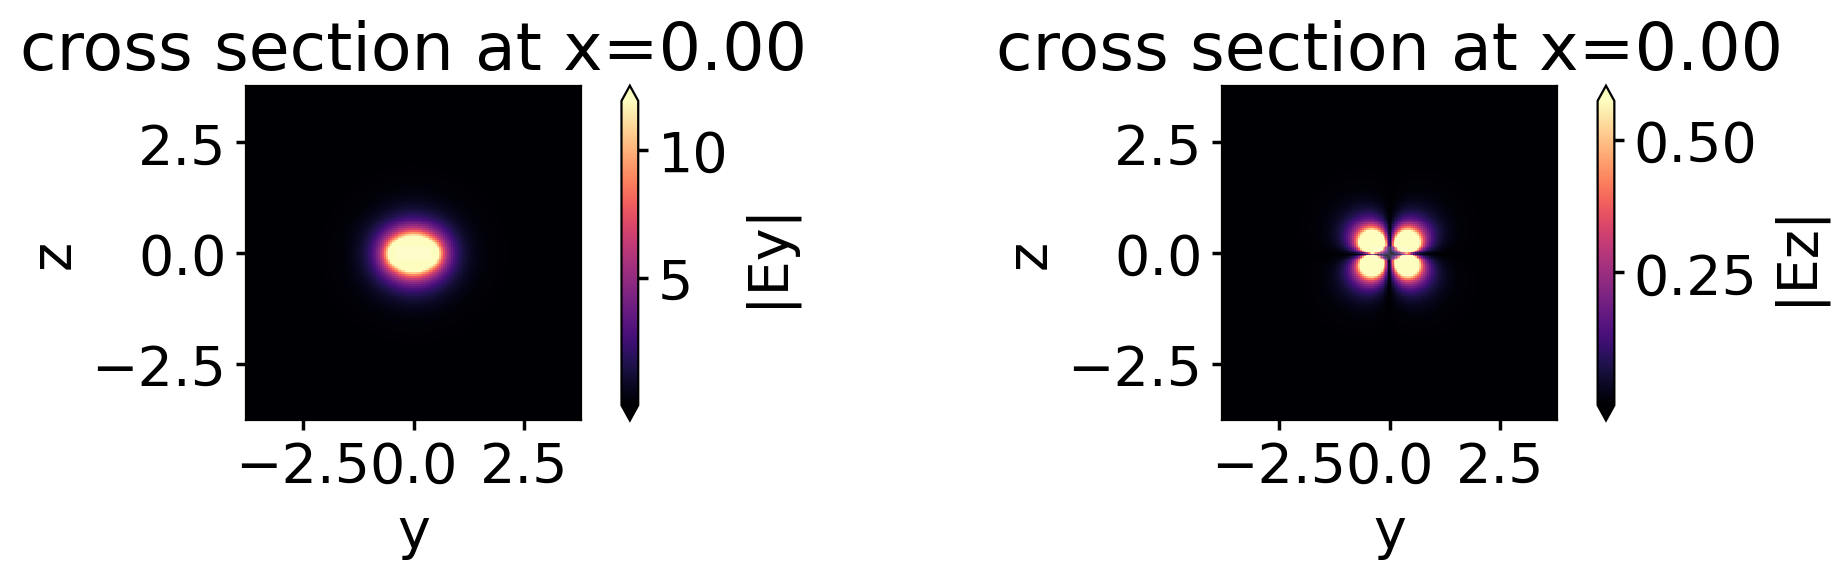

1.9305727 0.003636658191680908 1.587703 0.002396881580352783


In [3]:
# Mode solver
mode_solver, mode_data_df = mode_data_calculator(
    wg_width_median_array[0], wg_height_median, wg_sidewall_angle_median, wg_n, wg_k, freqs, freq0, Lx=Lx, Ly=Ly, Lz=Lz, dl=dl, min_steps_per_wvl=min_steps_per_wvl
    )

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_solver.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
mode_solver.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
plt.show()

## Calculating the group index
fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
ng_freq0 = fundamental_mode_data_df["group index"].values[0]
ng_dfreq = (mode_data_df["group index"].values[-1] - mode_data_df["group index"].values[0])/2
neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
neff_dfreq = (mode_data_df["n eff"].values[-1] - mode_data_df["n eff"].values[0])/2
print(ng_freq0, ng_dfreq, neff_freq0, neff_dfreq)

In [4]:
wg_height_spread, wg_width_spread, wg_sidewall_angle_spread = [], [], []

for idd_width in range(len(wg_width_median_array)):
  for idd_num_samples in tqdm(range(num_samples),desc = "variation sweep"):
    wg_height_spread.append((1+np.random.normal(0, thickness_3sigma/3/wg_height_median)))
    wg_width_spread.append((1+np.random.normal(0, width_3sigma/3/wg_width_median_array[idd_width])))
    wg_sidewall_angle_spread.append((1+np.random.normal(0,sidewall_angle_3sigma/3/wg_sidewall_angle_median)))

permutation_choice_width, permutation_choice_height, permutation_choice_sidewall_angle = np.random.permutation(num_samples), np.random.permutation(num_samples), np.random.permutation(num_samples)

wg_width_choice, wg_height_choice, wg_sidewall_angle_choice = [], [], []
ng_freq0_spread = []
ng_dfreq_spread = []
neff_freq0_spread = []
neff_dfreq_spread = []
wg_width_median_choice = []

for idd_width in range(len(wg_width_median_array)):
  for idd_num_samples in tqdm(range(num_samples), desc="mode_simulations"):
    rand_wg_width_choice = wg_width_spread[permutation_choice_width[idd_num_samples]] * wg_width_median_array[idd_width]
    wg_width_median_choice.append(wg_width_median_array[idd_width])
    rand_wg_height_choice = wg_height_spread[permutation_choice_height[idd_num_samples]] * wg_height_median
    rand_wg_sidewall_angle_choice = wg_sidewall_angle_spread[permutation_choice_sidewall_angle[idd_num_samples]] * wg_sidewall_angle_median

    wg_width_choice.append(rand_wg_width_choice)
    wg_height_choice.append(rand_wg_height_choice)
    wg_sidewall_angle_choice.append(rand_wg_sidewall_angle_choice)

    mode_solver, mode_data_df = mode_data_calculator(
        rand_wg_width_choice, 
        rand_wg_height_choice, 
        rand_wg_sidewall_angle_choice, 
        wg_n, wg_k, freqs, freq0, 
        Lx=Lx, Ly=Ly, Lz=Lz, dl=dl,
        min_steps_per_wvl=min_steps_per_wvl
    )

    fundamental_mode_data_df = mode_data_df[mode_data_df["wavelength"] == 1.31]
    ng_freq0 = fundamental_mode_data_df["group index"].values[0]
    ng_dfreq = (mode_data_df["group index"].values[-1] -
                mode_data_df["group index"].values[0])/2
    neff_freq0 = fundamental_mode_data_df["n eff"].values[0]
    neff_dfreq = (mode_data_df["n eff"].values[-1] -
                  mode_data_df["n eff"].values[0])/2
    
    ng_freq0_spread.append(ng_freq0)
    ng_dfreq_spread.append(ng_dfreq)
    neff_freq0_spread.append(neff_freq0)
    neff_dfreq_spread.append(neff_dfreq)

mode_simulations: 100%|██████████| 500/500 [1:05:16<00:00,  7.83s/it]


In [5]:
## Export in xarray Dataset
wg_width_choice_array = np.array(wg_width_choice).reshape(len(wg_width_median_array), num_samples)
wg_height_choice_array = np.array(wg_height_choice).reshape(len(wg_width_median_array), num_samples)
wg_sidewall_angle_choice_array = np.array(wg_sidewall_angle_choice).reshape(len(wg_width_median_array), num_samples)
wg_width_median_choice_array = np.array(wg_width_median_choice).reshape(len(wg_width_median_array), num_samples)
neff_freq0_spread_array = np.array(neff_freq0_spread).reshape(len(wg_width_median_array), num_samples)
neff_dfreq_spread_array = np.array(neff_dfreq_spread).reshape(len(wg_width_median_array), num_samples)
ng_freq0_spread_array = np.array(ng_freq0_spread).reshape(len(wg_width_median_array), num_samples)
ng_dfreq_spread_array = np.array(ng_dfreq_spread).reshape(len(wg_width_median_array), num_samples)

xr_rand_dataset = xr.Dataset(
  data_vars= dict(
    wg_width = (('wg_width_median_array','num_samples'), wg_width_choice_array),
    wg_height = (('wg_width_median_array','num_samples'), wg_height_choice_array),
    wg_sidewall_angle = (('wg_width_median_array','num_samples'), wg_sidewall_angle_choice_array),
    wg_width_median = (('wg_width_median_array','num_samples'), wg_width_median_choice_array),
    neff_freq0 = (('wg_width_median_array','num_samples'), neff_freq0_spread_array),
    neff_dfreq = (('wg_width_median_array','num_samples'), neff_dfreq_spread_array),
    ng_freq0 = (('wg_width_median_array','num_samples'), ng_freq0_spread_array),
    ng_dfreq = (('wg_width_median_array','num_samples'), ng_dfreq_spread_array),
  ),
  coords = dict(
    num_samples = np.arange(num_samples),
    wg_width_median_array = wg_width_median_array
  ),
  attrs = dict(description = "gf45clo_pdk_sin_neff_ng_variability")
)

xr_rand_dataset.to_netcdf("gf45clo_pdk_sin_neff_ng_variability.nc")

## Export in Pandas DataFrame

pd_rand_dataset = pd.DataFrame(data=wg_width_choice)
pd_rand_dataset.columns = ['wg_width (nm)']
pd_rand_dataset['wg_height (nm)']=wg_height_choice
pd_rand_dataset['wg_sidewall_angle (rad)'] = wg_sidewall_angle_choice
pd_rand_dataset['wg_width_median (nm)'] = wg_width_median_choice
pd_rand_dataset['neff_freq0'] = neff_freq0_spread
pd_rand_dataset['neff_dfreq'] = neff_dfreq_spread
pd_rand_dataset['ng_freq0'] = ng_freq0_spread
pd_rand_dataset['ng_dfreq'] = ng_dfreq_spread
pd_rand_dataset['freq0 (Hz)']=freq0
pd_rand_dataset['freq_lo (Hz)'] = freqs[0]
pd_rand_dataset['freq_hi (Hz)'] = freqs[-1]
gf45clo_pdk_sin_neff_ng_variability = pd_rand_dataset.copy(deep=True)
gf45clo_pdk_sin_neff_ng_variability.to_csv("gf45clo_pdk_sin_neff_ng_variability.csv")

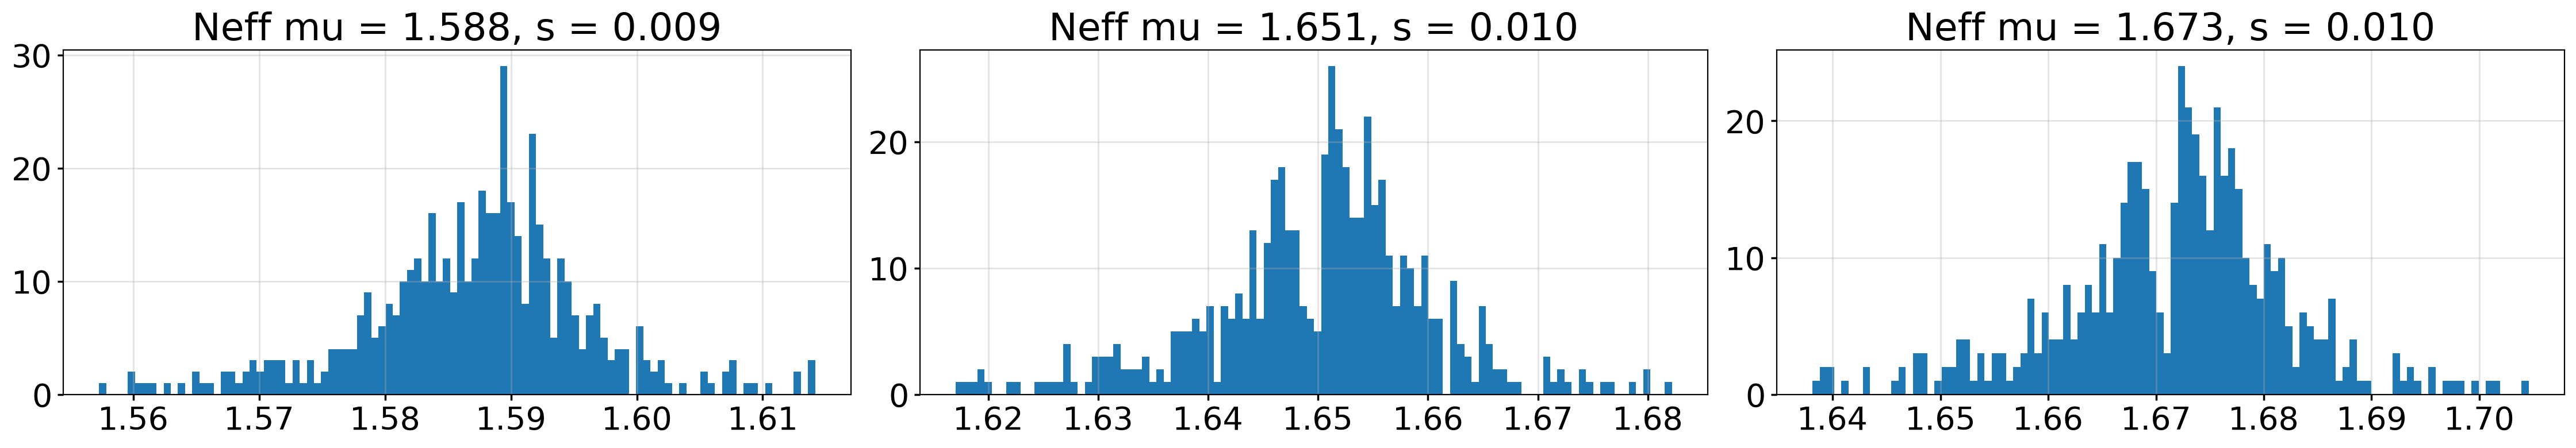

In [8]:
plt.figure(figsize=(7.5*len(xr_rand_dataset['wg_width_median_array'].values),4))
for idd_width, width in enumerate(xr_rand_dataset['wg_width_median_array'].values):
  plt.subplot(1, int(len(xr_rand_dataset['wg_width_median_array'].values)), idd_width+1)
  plt.hist(xr_rand_dataset['neff_freq0'].sel(wg_width_median_array=width), bins=100)
  median = xr_rand_dataset['neff_freq0'].sel(wg_width_median_array=width).median()
  std = xr_rand_dataset['neff_freq0'].sel(wg_width_median_array=width).std()
  plt.title(f'Neff mu = {median:0.3f}, s = {std:0.3f}')

plt.tight_layout()

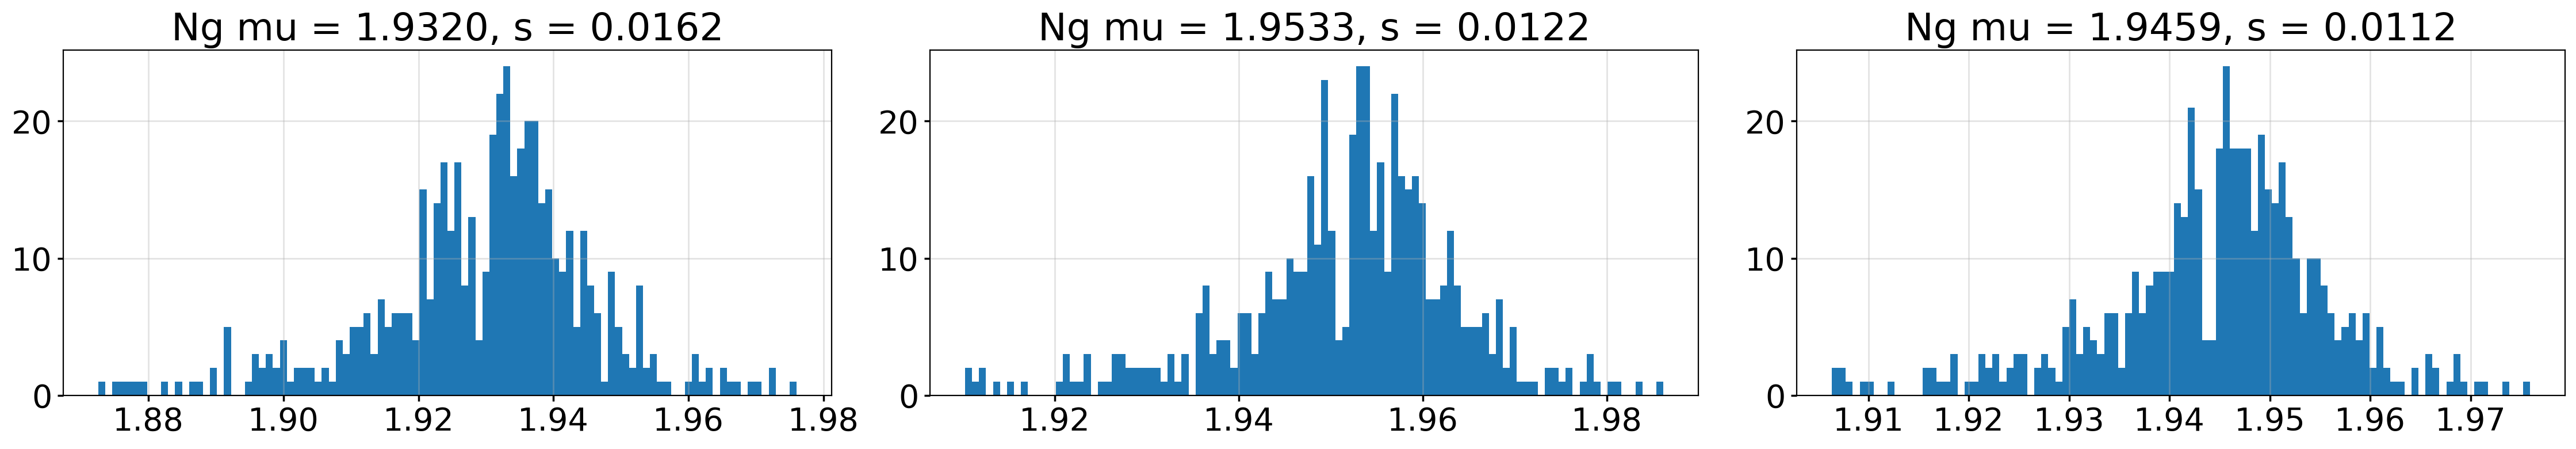

In [10]:
plt.figure(figsize=(7.5*len(xr_rand_dataset['wg_width_median_array'].values),4))
for idd_width, width in enumerate(xr_rand_dataset['wg_width_median_array'].values):
  plt.subplot(1, int(len(xr_rand_dataset['wg_width_median_array'].values)), idd_width+1)
  plt.hist(xr_rand_dataset['ng_freq0'].sel(wg_width_median_array=width), bins=100)
  median = xr_rand_dataset['ng_freq0'].sel(wg_width_median_array=width).median()
  std = xr_rand_dataset['ng_freq0'].sel(wg_width_median_array=width).std()
  plt.title(f'Ng mu = {median:0.4f}, s = {std:0.4f}')

plt.tight_layout()

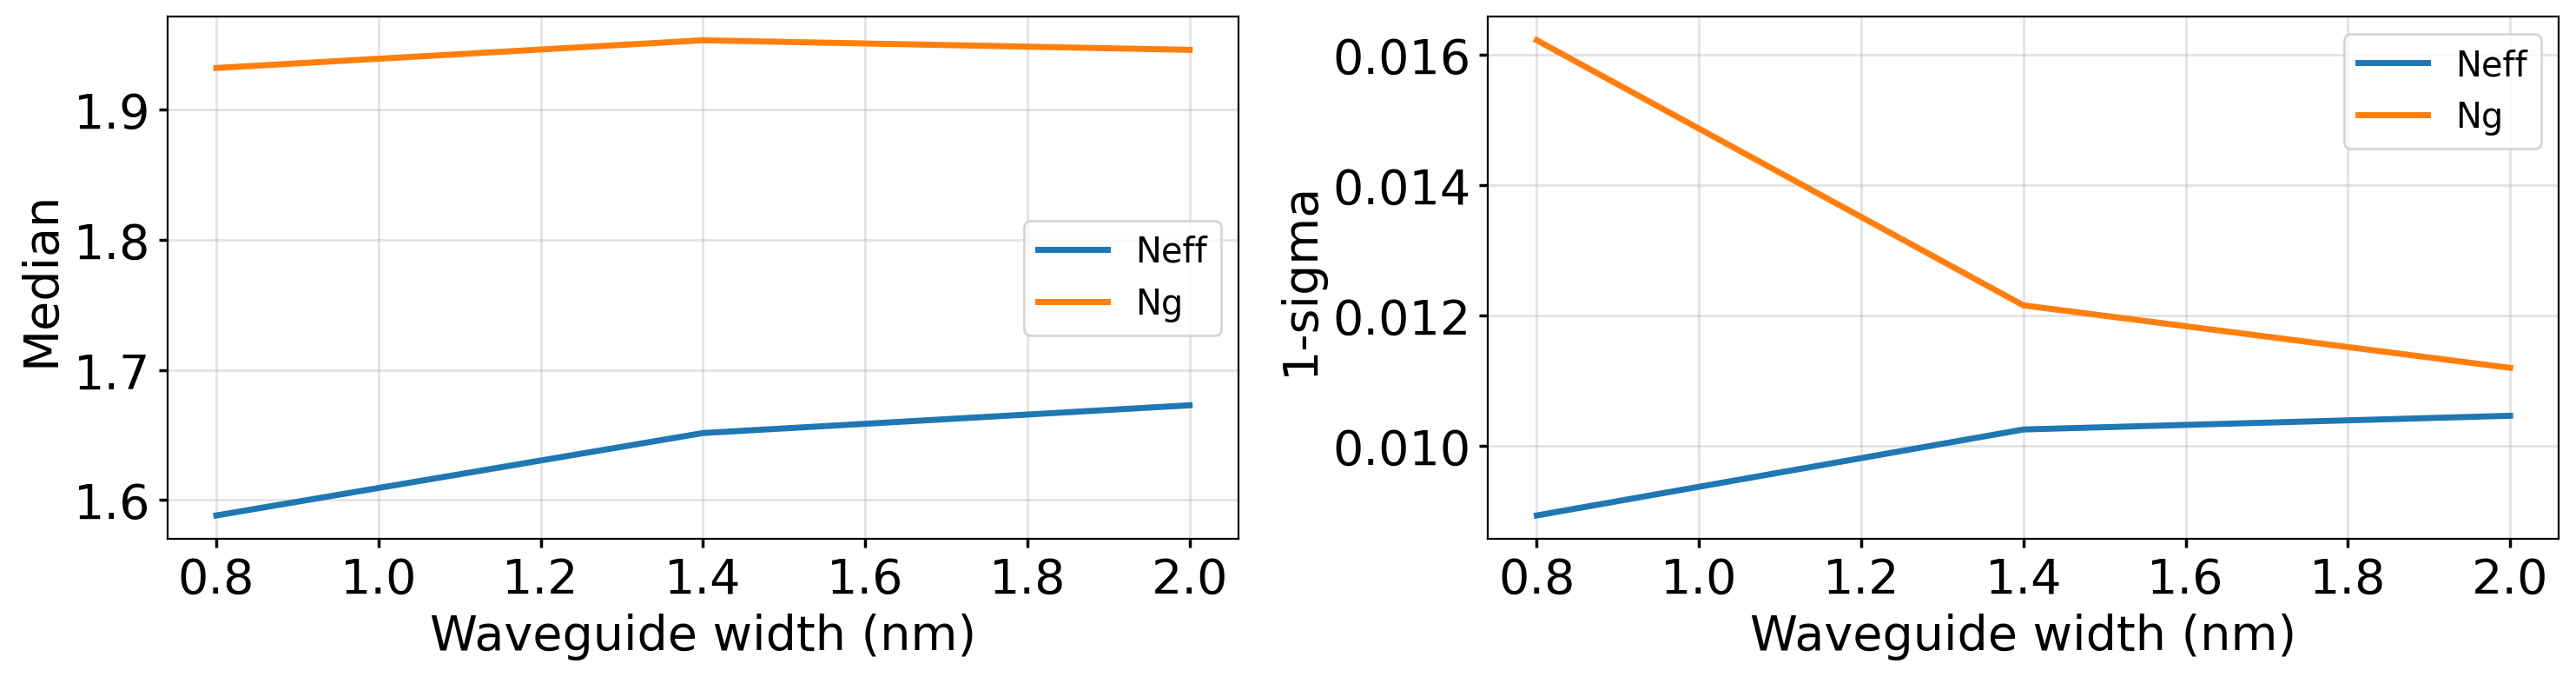

In [11]:
plt.figure(figsize=(15,4))
std_ng = []
std_neff = []
mu_ng = []
mu_neff = []
for idd_width, width in enumerate(xr_rand_dataset['wg_width_median_array'].values):
  std_ng.append(xr_rand_dataset['ng_freq0'].sel(wg_width_median_array=width).std())
  std_neff.append(xr_rand_dataset['neff_freq0'].sel(wg_width_median_array=width).std())
  mu_ng.append(xr_rand_dataset['ng_freq0'].sel(wg_width_median_array=width).median())
  mu_neff.append(xr_rand_dataset['neff_freq0'].sel(wg_width_median_array=width).median())
plt.subplot(121)
plt.plot(xr_rand_dataset['wg_width_median_array'].values,mu_neff, label="Neff")
plt.plot(xr_rand_dataset['wg_width_median_array'].values,mu_ng, label="Ng")
plt.xlabel("Waveguide width (nm)")
plt.ylabel("Median")
plt.legend()
plt.subplot(122)
plt.plot(xr_rand_dataset['wg_width_median_array'].values,std_neff, label="Neff")
plt.plot(xr_rand_dataset['wg_width_median_array'].values,std_ng, label="Ng")
plt.xlabel("Waveguide width (nm)")
plt.ylabel("1-sigma")
plt.legend()
plt.tight_layout()